In [1]:
# Import modules
import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

import collections
from moviepy.editor import VideoFileClip

/Users/TX/anaconda/envs/carnd-term1/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Camera Calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y


objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)
# cv2.destroyAllWindows()

In [3]:
# Undistort the image
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

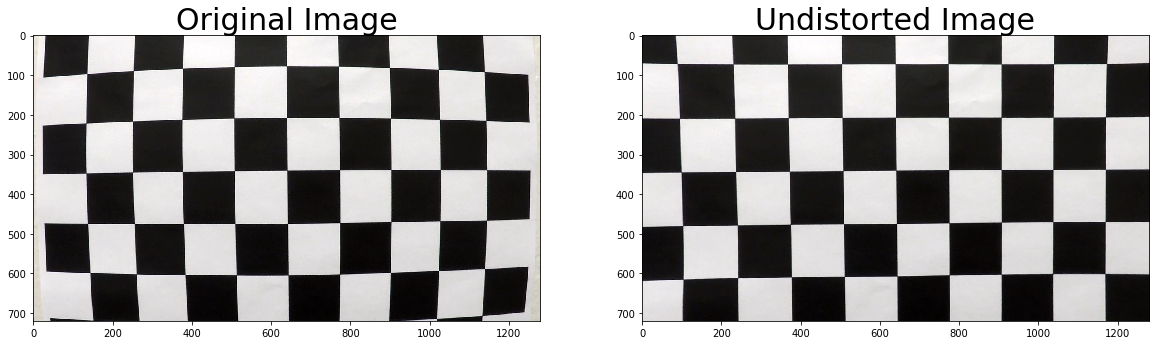

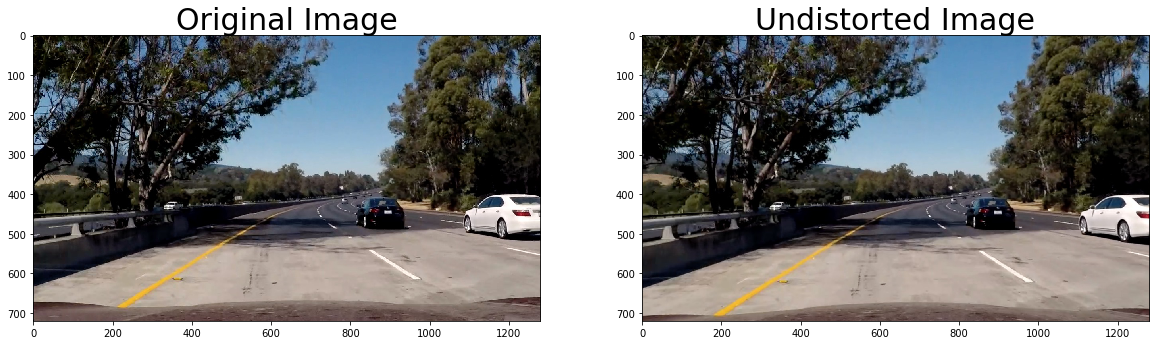

In [4]:
# # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist
# pickle.dump(dist_pickle, open("camera_cal/wide_dist_pickle.p", "wb" ) )
# #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open("camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration1.jpg')
dst = undistort(img)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

test5 = mpimg.imread('test_images/test5.jpg')
test5_undist = undistort(test5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test5)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test5_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Different Thresholding Functions

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary

In [6]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

In [7]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

In [8]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

In [9]:
def color_mask(img):
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    yellow_hsv_low  = np.array([0,  100,  100])
    yellow_hsv_high = np.array([100, 255, 255])
    mask_yellow = cv2.inRange(image_HSV, yellow_hsv_low, yellow_hsv_high)
#     res_yellow = cv2.bitwise_and(image,image, mask= mask_yellow)
    
    
    sensitivity = 45
    white_hsv_low  = np.array([0, 0,255 - sensitivity])
    white_hsv_high = np.array([255, sensitivity, 255])
    mask_white = cv2.inRange(image_HSV, white_hsv_low, white_hsv_high)
#     res_white= cv2.bitwise_and(image,image, mask= mask_white)
    binary_out = np.zeros_like(img[:,:,0])
    binary_out[(mask_yellow!=0) | (mask_white!=0)] =1
    
#     binary_out = cv2.bitwise_or(mask_yellow, mask_white)
    
    return binary_out

## Interactive Thresholding Adjustment

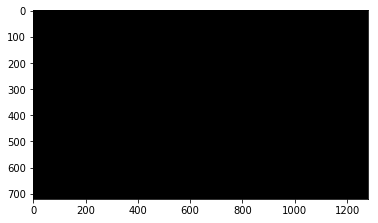

In [10]:
# Combining thresholds
image = mpimg.imread('test_images/test1.jpg')
def update(ksize, min_gradx, max_gradx, min_grady, max_grady, min_mag, max_mag, min_dir, max_dir, min_s, max_s, min_v, max_v):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(min_gradx,max_gradx))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(min_grady,max_grady))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(min_mag,max_mag))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(min_dir,max_dir))
#     s_binary = hls_select(image, thresh=(min_s,max_s))
    white_yellow_binary = color_mask(image)
    
    combined = np.zeros_like(gradx)
#     combined[(gradx == 1) & (grady == 1) | (vs_binary == 1)] = 1
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((s_binary == 1))] = 1
#     color_binary = np.zeros_like(gradx)
#     color_binary[(combined == 1) | (vs_binary == 1)] = 1
    combined[((white_yellow_binary ==1) & ((dir_binary == 1) | (mag_binary == 1)))] = 1
    plt.imshow(combined, cmap='gray')

interact(update, ksize=(1,31,2),
         min_gradx=(0,255), max_gradx=(0,255),
         min_grady=(0,255), max_grady=(0,255),
         min_mag = (0,255), max_mag = (0,255),
         min_dir=(0,np.pi/2), max_dir=(0,np.pi/2),
         min_s   = (0,255),    max_s = (0,255),
         min_v   = (0,255),    max_v = (0,255));

## Adjust HSV Value to Detect Yellow and White Lines

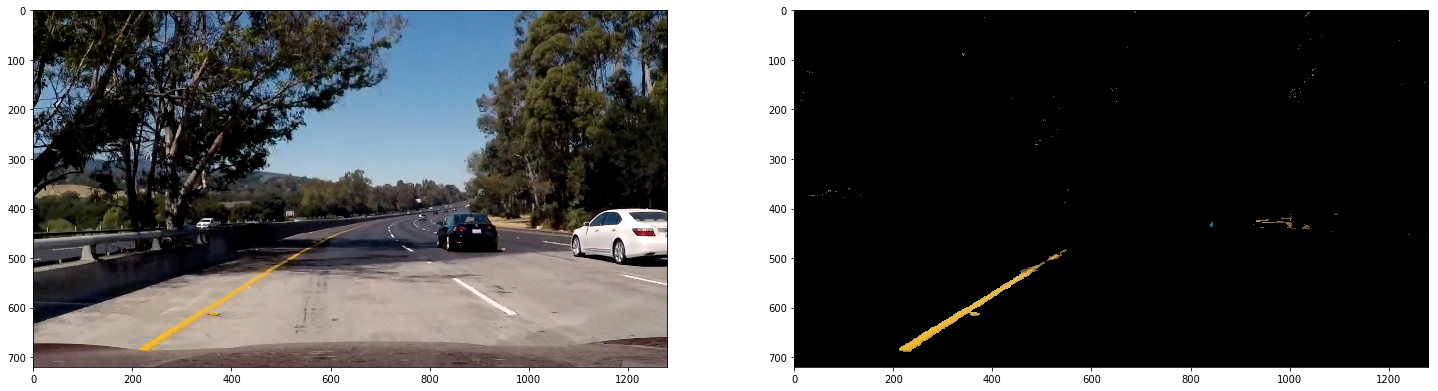

In [11]:
image = mpimg.imread('test_images/test5.jpg')
image_HSV = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 100, 255, 255])
mask_yellow = cv2.inRange(image_HSV, yellow_hsv_low, yellow_hsv_high)
res_yellow = cv2.bitwise_and(image,image, mask= mask_yellow)
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(res_yellow)

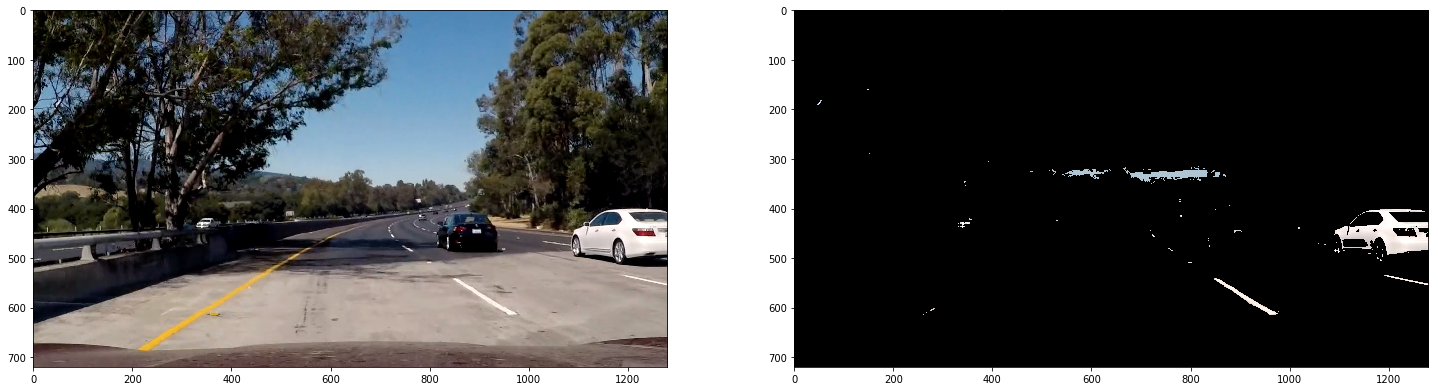

In [12]:
# Source: http://stackoverflow.com/questions/22588146/tracking-white-color-using-python-opencv
image = mpimg.imread('test_images/test5.jpg')
image_HSV = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
sensitivity = 45
white_hsv_low  = np.array([ 0, 0,255 - sensitivity])
white_hsv_high = np.array([ 255, sensitivity, 255])
mask_white = cv2.inRange(image_HSV, white_hsv_low, white_hsv_high)
res_white= cv2.bitwise_and(image,image, mask= mask_white)
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(res_white)

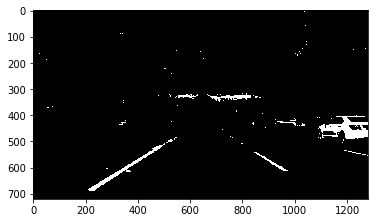

In [13]:
# Combine yellow and white mask
image = mpimg.imread('test_images/test5.jpg')
out_image = color_mask(image)
plt.imshow(out_image,cmap='gray')

## Thresholding Pipeline & Testing

In [14]:
def thresh_pipeline(image, ksize=15, min_mag=50, max_mag=220, min_dir=0.7, max_dir=1.20):
    # Apply each of the thresholding functions

    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(min_mag,max_mag))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(min_dir,max_dir))
    white_yellow_binary = color_mask(image)
    combined = np.zeros_like(mag_binary)
    combined[((white_yellow_binary ==1) & ((dir_binary == 1) | (mag_binary == 1)))] = 1
    return combined

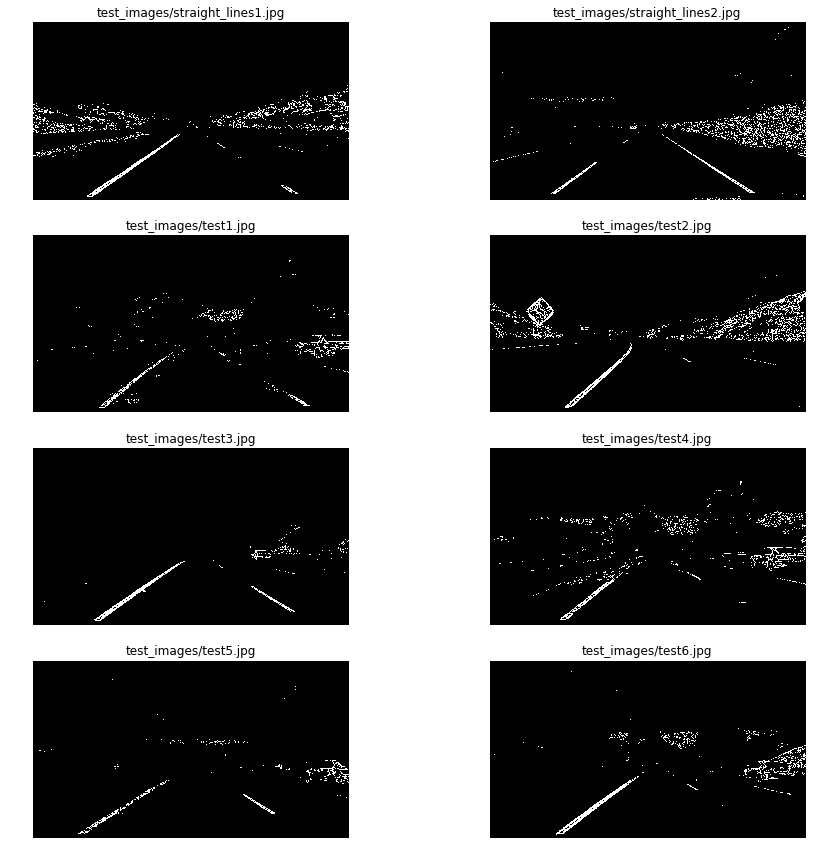

In [15]:
images = glob.glob('test_images/*.jpg')
plt.figure(figsize=(15,15))
for idx, fname in enumerate(images):
    plt.subplot(4,2,idx+1)
    img = mpimg.imread(fname)
    img_undist = undistort(img)
    img_binary = thresh_pipeline(img_undist)
    plt.axis('off')
    plt.title(fname)
    plt.imshow(img_binary, cmap='gray')

## Perspective Transform (Bird-eye View)

In [16]:
# Perspective transform on unistorted image
def perspective_transform(img):
    img_size = img.shape[0:2]
    height = img_size[0] #720
    width = img_size[1] #1280
    top_left_x = width * 0.45 #576
    top_right_x = width * 0.55 #704
    top_y = height * 0.63 #453
    dst_top_left_x = width * 0.25 # 320
    dst_top_right_x = width * 0.75 # 960
    
    src = np.float32([[top_left_x, top_y], [top_right_x, top_y],
                       [width, height], [0, height]])
    dst = np.float32([[dst_top_left_x, 0], [dst_top_right_x, 0], 
                      [dst_top_right_x, height], [dst_top_left_x, height]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped, Minv

## Plot Original, Top-down and Histogram

In [17]:
def plot_ori_bird(image):
    img_undist = undistort(image)
    img_binary = thresh_pipeline(img_undist)
    top_down, Minv = perspective_transform(img_binary)
    histogram = np.sum(top_down[top_down.shape[0]/2:,:], axis=0);
    
    
    plt.figure(figsize=(13,2))
    plt.subplot(1,3,1)
    plt.imshow(img_binary,cmap='gray')
    plt.title('Binary')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(top_down,cmap='gray')
    plt.title('Bird-eye view')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.plot(histogram)
    plt.title('Histogram')

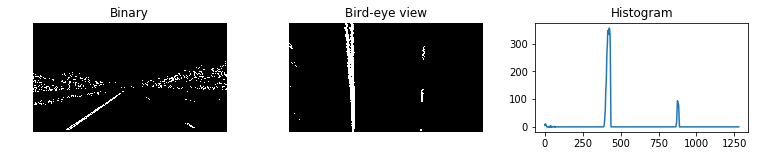

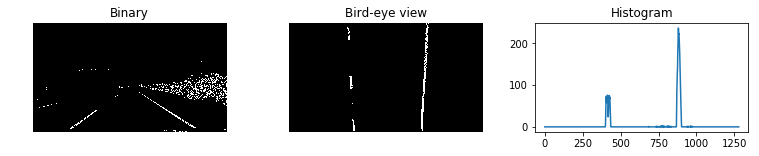

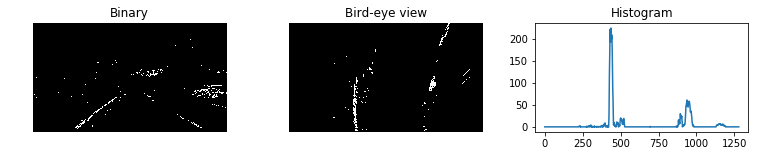

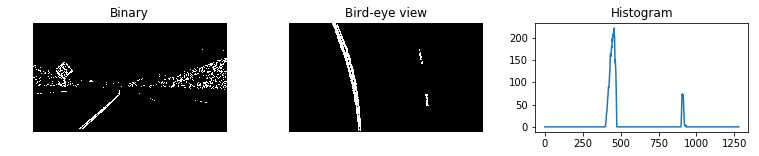

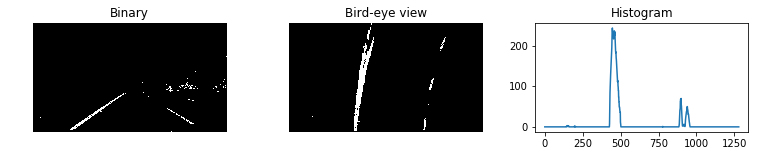

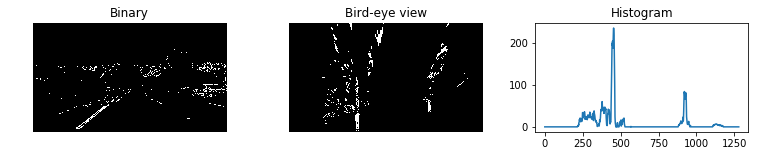

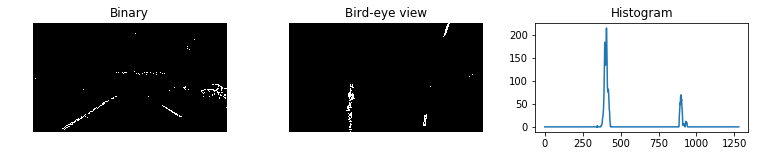

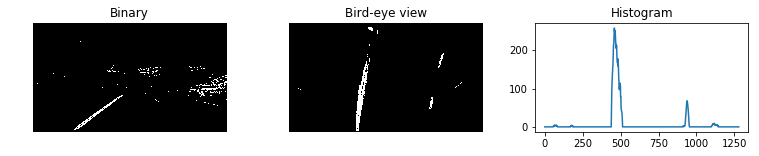

In [18]:
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    plot_ori_bird(img)

## Fit Lines Using Sliding Windows & Polynomial Fitting

In [19]:
image = mpimg.imread('test_images/test6.jpg')
img_undist = undistort(image)
img_binary = thresh_pipeline(img_undist)
top_down, Minv = perspective_transform(img_binary)
histogram = np.sum(top_down[top_down.shape[0]/2:,:], axis=0);
binary_warped = top_down
# plt.imshow(binary_warped,cmap='gray')

In [20]:
def detect_lines(binary_warped, left_fit=None, right_fit=None):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Search for initial left and right lanes
    if left_fit is None and right_fit is None:
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#         print("leftx_base",leftx_base, "rightx_base",rightx_base)


        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            
#             print('left pixel', good_left_inds)
#             print('len of left pixel', len(good_left_inds))
            
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    # Use previous left and right lines to detect furthrer lines
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        
#     print('left lane inds len is ', len(left_lane_inds))
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
#     print(nonzerox)
#     print(left_lane_inds)
#     print(lefty)
    

    if (len(leftx) == 0 | len(lefty) == 0):
        left_fit = prev_left_fit
    else:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if (len(rightx) == 0 | len(righty) == 0):
        right_fit = prev_right_fit
    else:
        # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)

    # Create an output image to draw on and  visualize the result
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return len(left_lane_inds), left_fit, right_fit, out_img

In [27]:
# Source: http://stackoverflow.com/questions/4151320/efficient-circular-buffer
global avg_left_fit, avg_right_fit, prev_left_fit, prev_right_fit
num_frames=15
avg_left_fit = collections.deque(maxlen = num_frames)
avg_right_fit = collections.deque(maxlen = num_frames)
prev_left_fit = None
prev_right_fit = None

def smooth_frames(left_fit, right_fit):        
    if (len(avg_left_fit)!=0):
        new_avg_left_fit = np.sum(avg_left_fit, axis=0)/len(avg_left_fit)
        print('length not zero')
        new_avg_left_fit = 0.95 * new_avg_left_fit + 0.05 * left_fit
    else:
        new_avg_left_fit = left_fit
        print('length is zero')
    
    if (len(avg_right_fit)!=0):    
        new_avg_right_fit = np.sum(avg_right_fit, axis=0)/len(avg_right_fit)
        new_avg_right_fit = 0.95 * new_avg_right_fit + 0.05 * right_fit
    else:
        new_avg_right_fit = right_fit

    avg_left_fit.append(left_fit)
    avg_right_fit.append(right_fit) 
    
    prev_left_fit = new_avg_left_fit
    prev_right_fit = new_avg_right_fit
    
    return new_avg_left_fit, new_avg_right_fit

## Visualization

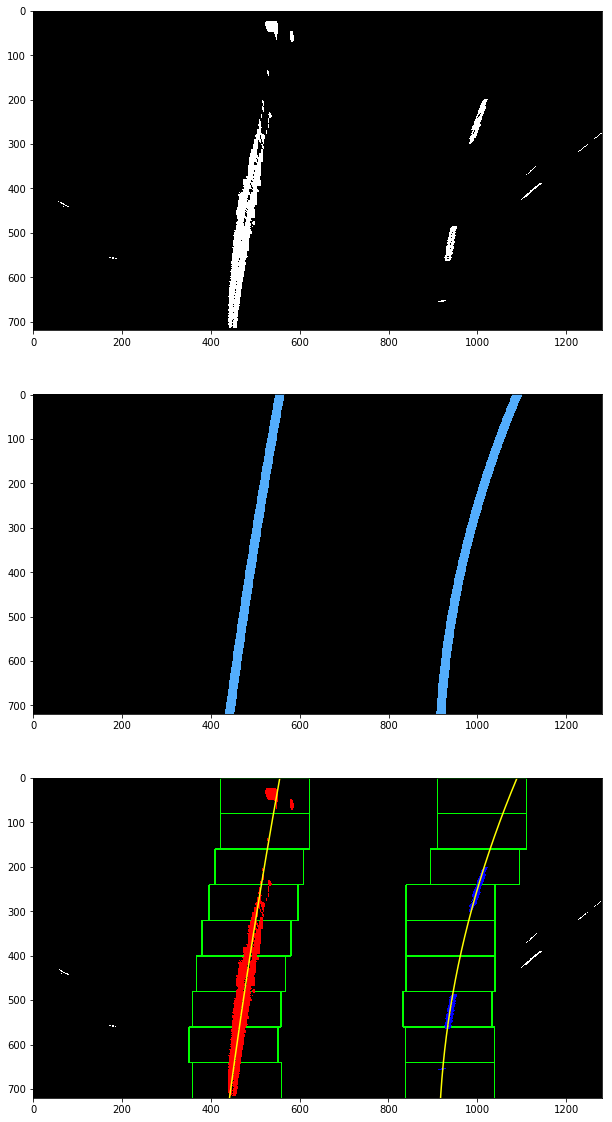

In [28]:
# Generate x and y values for plotting
len_left_lane_inds, left_fit, right_fit,out_img = detect_lines(binary_warped)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(30,20))
plt.subplot(3,1,1)
plt.imshow(binary_warped, cmap='gray')


warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
# Draw the lane onto the warped blank image

cv2.polylines(color_warp, np.int_([pts_left]), False, (83, 173, 252), 20)
cv2.polylines(color_warp, np.int_([pts_right]), False, (83, 173, 252), 20)
plt.subplot(3,1,2)
plt.imshow(color_warp)


plt.subplot(3,1,3)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

## Curvature and Offset Center Calculation

In [29]:
def calculate_curvature(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curverad = 0.5*(left_curverad + right_curverad)    
    return avg_curverad

In [30]:
def offset_center(left_fitx, right_fitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_x = left_fitx[-1]
    right_x = right_fitx[-1]
    center_x = 0.5*(left_x + right_x)
    offset_x = (1280/2 - center_x) * xm_per_pix
    return offset_x

## Fill The Mask

In [31]:
def add_line_mask(warped, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int_([pts_left]), False, (83, 173, 252), 20)
    cv2.polylines(color_warp, np.int_([pts_right]), False, (83, 173, 252), 20)
    return color_warp

## Pipeline Test

length is zero
left_fit is [ -4.66803234e-04   5.41004198e-01   2.84679606e+02]
smooth left_fit is  [ -4.66803234e-04   5.41004198e-01   2.84679606e+02]


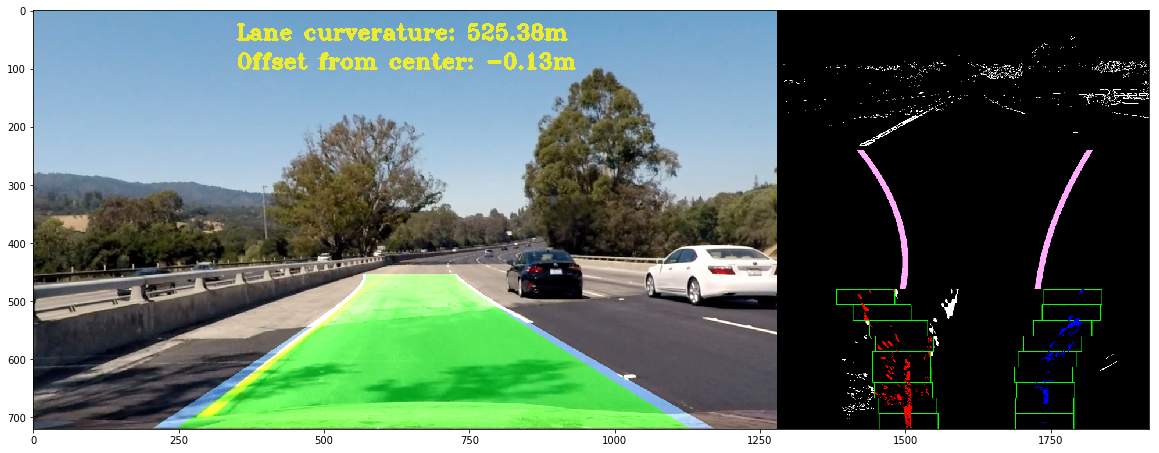

In [32]:
image = mpimg.imread('test_images/test4.jpg')
img_undist = undistort(image)
img_binary = thresh_pipeline(img_undist)
top_down, Minv = perspective_transform(img_binary)


# Current fit coeff and smoothed fit coeff
#********************************************************************************************#
len_left_lane_inds, left_fit, right_fit, test_img = detect_lines(top_down)
smooth_left_fit, smooth_right_fit = smooth_frames(left_fit, right_fit)
#********************************************************************************************#
print('left_fit is', left_fit)
print('smooth left_fit is ', smooth_left_fit)


ploty = np.linspace(0, 719, 720)

# Current fit lines and smoothed fit lines
#********************************************************************************************#
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


smooth_left_fitx = smooth_left_fit[0]*ploty**2 + smooth_left_fit[1]*ploty + smooth_left_fit[2]
smooth_right_fitx = smooth_right_fit[0]*ploty**2 + smooth_right_fit[1]*ploty + smooth_right_fit[2]
#********************************************************************************************#

curverature = calculate_curvature(ploty, smooth_left_fitx, smooth_right_fitx)
off_center = offset_center(smooth_left_fitx, smooth_right_fitx)

color_warp = add_line_mask(img_binary, ploty, smooth_left_fitx, smooth_right_fitx)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(img_undist, 1, newwarp, 0.6, 0)
cv2.putText(result, "Lane curverature: %.2fm" % curverature, (350, 50), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)
cv2.putText(result, "Offset from center: %.2fm" % (off_center), (350, 100), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)

# cv2.putText(result, "Left fit coeff A : %.2f" % (left_fit[0]), (350, 150), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)
# cv2.putText(result, "Left fit coeff B : %.2f" % (left_fit[1]), (350, 200), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)
# cv2.putText(result, "Left fit coeff C : %.2f" % (left_fit[2]), (350, 250), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)
# cv2.putText(result, "Left lane inds length : %.2f" % (len_left_lane_inds), (350, 300), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)

warp_zero = np.zeros_like(top_down).astype(np.uint8)
top_line_fitting = np.dstack((warp_zero, warp_zero, warp_zero))

#********************************************************************************************#
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
smooth_pts_left = np.array([np.transpose(np.vstack([smooth_left_fitx, ploty]))])
smooth_pts_right = np.array([np.flipud(np.transpose(np.vstack([smooth_right_fitx, ploty])))])
#********************************************************************************************#
    
# Draw the lane onto the warped blank image
#********************************************************************************************#
cv2.polylines(top_line_fitting, np.int_([pts_left]), False, (83, 173, 252), 20)
cv2.polylines(top_line_fitting, np.int_([pts_right]), False, (83, 173, 252), 20)


cv2.polylines(top_line_fitting, np.int_([smooth_pts_left]), False, (255, 173, 252), 20)
cv2.polylines(top_line_fitting, np.int_([smooth_pts_right]), False, (255, 173, 252), 20)
#********************************************************************************************#

img_out=np.zeros((720,1920,3), dtype=np.uint8)

img_out[0:720, 0:1280] = result

# Threshold
img_out[0:240,1280:1920] = cv2.resize(np.stack((255*img_binary, 255*img_binary,255*img_binary), axis=2),(640,240))

# Birds eye view
img_out[240:480,1280:1920] = cv2.resize(top_line_fitting,(640,240))

#test_img
img_out[480:720,1280:1920] = cv2.resize(test_img,(640,240))

plt.figure(figsize=(20,20))
plt.imshow(img_out)

In [33]:
def pipeline(image, prev_left_fit, prev_right_fit):
    img_undist = undistort(image)
    img_binary = thresh_pipeline(img_undist)
    top_down, Minv = perspective_transform(img_binary)
    
    # Current fit coeff and smoothed fit coeff
    #********************************************************************************************#
    len_left_lane_inds, left_fit, right_fit, test_img = detect_lines(top_down)
    smooth_left_fit, smooth_right_fit = smooth_frames(left_fit, right_fit)
    #********************************************************************************************#
    print('left_fit is', left_fit)
    print('smooth left_fit is ', smooth_left_fit)


    ploty = np.linspace(0, 719, 720)

    # Current fit lines and smoothed fit lines
    #********************************************************************************************#
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    smooth_left_fitx = smooth_left_fit[0]*ploty**2 + smooth_left_fit[1]*ploty + smooth_left_fit[2]
    smooth_right_fitx = smooth_right_fit[0]*ploty**2 + smooth_right_fit[1]*ploty + smooth_right_fit[2]
    #********************************************************************************************#

    curverature = calculate_curvature(ploty, smooth_left_fitx, smooth_right_fitx)
    off_center = offset_center(smooth_left_fitx, smooth_right_fitx)

    color_warp = add_line_mask(img_binary, ploty, smooth_left_fitx, smooth_right_fitx)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.6, 0)
    cv2.putText(result, "Lane curverature: %.2fm" % curverature, (350, 50), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)
    cv2.putText(result, "Offset from center: %.2fm" % (off_center), (350, 100), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)

    # cv2.putText(result, "Left fit coeff A : %.2f" % (left_fit[0]), (350, 150), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)
    # cv2.putText(result, "Left fit coeff B : %.2f" % (left_fit[1]), (350, 200), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)
    # cv2.putText(result, "Left fit coeff C : %.2f" % (left_fit[2]), (350, 250), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)
    # cv2.putText(result, "Left lane inds length : %.2f" % (len_left_lane_inds), (350, 300), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (235, 235, 50),3)

    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    top_line_fitting = np.dstack((warp_zero, warp_zero, warp_zero))

    #********************************************************************************************#
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    smooth_pts_left = np.array([np.transpose(np.vstack([smooth_left_fitx, ploty]))])
    smooth_pts_right = np.array([np.flipud(np.transpose(np.vstack([smooth_right_fitx, ploty])))])
    #********************************************************************************************#

    # Draw the lane onto the warped blank image
    #********************************************************************************************#
    cv2.polylines(top_line_fitting, np.int_([pts_left]), False, (83, 173, 252), 20)
    cv2.polylines(top_line_fitting, np.int_([pts_right]), False, (83, 173, 252), 20)


    cv2.polylines(top_line_fitting, np.int_([smooth_pts_left]), False, (255, 173, 252), 20)
    cv2.polylines(top_line_fitting, np.int_([smooth_pts_right]), False, (255, 173, 252), 20)
    #********************************************************************************************#

    img_out=np.zeros((720,1920,3), dtype=np.uint8)
    # Original 
    img_out[0:720, 0:1280] = result
    # Threshold
    img_out[0:240,1280:1920] = cv2.resize(np.stack((255*img_binary, 255*img_binary,255*img_binary), axis=2),(640,240))
    # Birds eye view with current and smooth lie fitting
    img_out[240:480,1280:1920] = cv2.resize(top_line_fitting,(640,240))
    # Birds eye view with window sliding box
    img_out[480:720,1280:1920] = cv2.resize(test_img,(640,240))
    
    return img_out, smooth_left_fit, smooth_right_fit

In [34]:
def process_image(image):
    global prev_left_fit, prev_right_fit
    out_img,prev_left_fit, prev_right_fit = pipeline(image, prev_left_fit, prev_right_fit)
    return out_img

In [35]:
# prev_left_fit = None
# prev_right_fit = None

# num_frames=15
# avg_left_fit = collections.deque(maxlen = num_frames)
# avg_right_fit = collections.deque(maxlen = num_frames)



# video_input = 'project_video'
# video_input = 'challenge_video'
# video_input = 'harder_challenge_video'
# video_output = '{}_solution.mp4'.format(video_input)
# clip1 = VideoFileClip('{}.mp4'.format(video_input)).subclip(0, 5)
# white_clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
# white_clip.write_videofile(video_output, audio=False)